# ImageNet Small dataset With InceptionV3

In practice, very few people train an entire Convolutional Network
from scratch (with random initialization), because it is relatively
rare to have a dataset of sufficient size. Instead, it is common to
pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
contains 1.2 million images with 1000 categories), and then use the
ConvNet either as an initialization or a fixed feature extractor for
the task of interest [CNN for Visual Recognition](https://cs231n.github.io/transfer-learning/).

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode


We will use torchvision and torch.utils.data packages for loading the data. [Original Notebook](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_inception_v3.ipynb)

The problem we're going to solve today is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet. Since this is imagenet dataset we can use the pretrained weights. If your own data is similar to a standard dataset, for example, CUB-200 data can be considered as a baseline data for bird detection, and [Inaturalist](https://github.com/visipedia/inat_comp) can be used as a baseline dataset for north american animal detection/recognition. Google's Imagenet is the most highly-used subset of ImageNet is the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012-2017 image classification and localization dataset. This dataset spans 1000 object classes and contains 1,281,167 training images, 50,000 validation images and 100,000 test images. This subset is available on [Kaggle](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description).

In [ ]:
# from zipfile import ZipFile
# file_name = ['/content/test - HSV.zip','/content/train - HSV.zip']
# for i in file_name:
#   with ZipFile(i, 'r') as z:
#     z.extractall()
#     print('Done')

In [ ]:
train_path = "/content/train - HSV"
# if not os.path.exists(train_path):
#     os.makedirs(train_path)

test_path = "/content/test - HSV"
# if not os.path.exists(test_path):
#     os.makedirs(test_path)
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

In [ ]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.348,0.384,0.411]
std = [0.094,0.067,0.0566]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(),
      torchvision.transforms.Resize(299),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 4,
    shuffle=True,
    num_workers = 4
)

test = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 4,
    shuffle=True,
    num_workers = 4
)
train_size = len(train)
test_size = len(test)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

Let's visualize a few training images so as to understand the data augmentations.

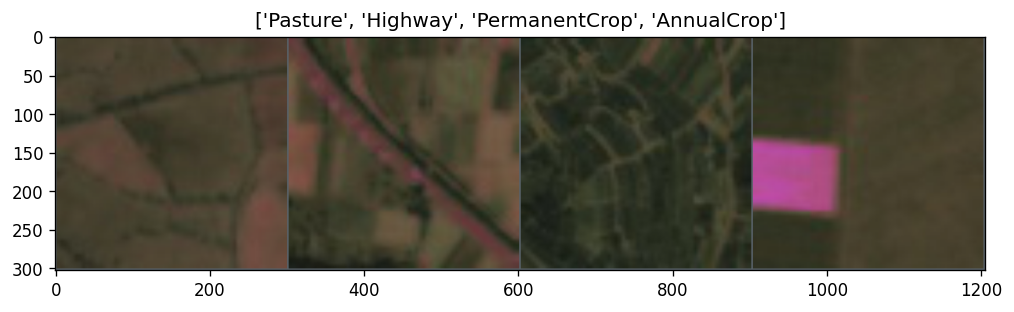

In [ ]:
plt.figure(figsize=(10,5), dpi=120)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.348,0.384,0.411]
    std = [0.094,0.067,0.0566]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, class_names = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in class_names])

# Training the model

Now, let's write a general function to train a model. Here, we will illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.

In [ ]:
from datetime import datetime
import tqdm as tqdm

num_epochs = 10

pbar = tqdm.tqdm(total=num_epochs, position=0, leave=True, colour='#336699')
pbar.set_description("EPOCH 1: Training Loss: NA, ")

def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()
    
    train_loss = [np.nan]
    train_accuracy = [np.nan]
    test_loss = [np.nan]
    test_accuracy = [np.nan]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
                size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = test_loader
                size = test_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        current_loss = loss.cpu().data.item()
                        running_loss += current_loss

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / size
            epoch_acc = running_corrects / size
            if phase =='train':
              train_loss.append(epoch_loss)
              train_accuracy.append(epoch_acc)
            else:
              test_loss.append(epoch_loss)
              test_accuracy.append(epoch_acc)

            pbar.set_description(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        pbar.update()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, test_loss, train_accuracy, test_accuracy

EPOCH 1: Training Loss: NA, :   0%|          | 0/10 [00:00<?, ?it/s]

# Visualizing the model predictions

Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(2, 2))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer. If you run the model and see a warning then you are probabily running torchvision version 1.12.

In [ ]:
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights

# Use this model parameters if your torch version is 1.11

model = models.inception_v3(pretrained=True)
model.aux_logits=False


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Use this model parameters if your torch version is 1.12 - My version
model = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')
model.aux_logits=False
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:

num_ftrs = model.fc.in_features
# print(num_ftrs)
# Here the size of each output sample is set to 2. In your model use nn.Linear(num_ftrs, len(class_names)) to generalize to your number of classes.
model.fc = nn.Linear(num_ftrs, 10)

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.


In [ ]:
# model_ft, train_loss, test_loss, train_accuracy, test_accuracy = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=num_epochs)

In [ ]:
# visualize_model(model_ft)

# ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)`.


In [ ]:
# Torchvision models V 1.11
# model_conv = torchvision.models.inception_v3(pretrained=True)
# Torchvision models V 1.12 - My version
model_conv = torchvision.models.inception_v3(weights='Inception_V3_Weights.DEFAULT')
model_conv.aux_logits=False


for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.

In [ ]:
model_conv,train_loss, test_loss, train_accuracy, test_accuracy = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=num_epochs)

val Loss: 0.7783 Acc: 0.7204: 100%|██████████| 10/10 [02:31<00:00, 14.85s/it]

Training complete in 2m 29s
Best val Acc: 0.770370


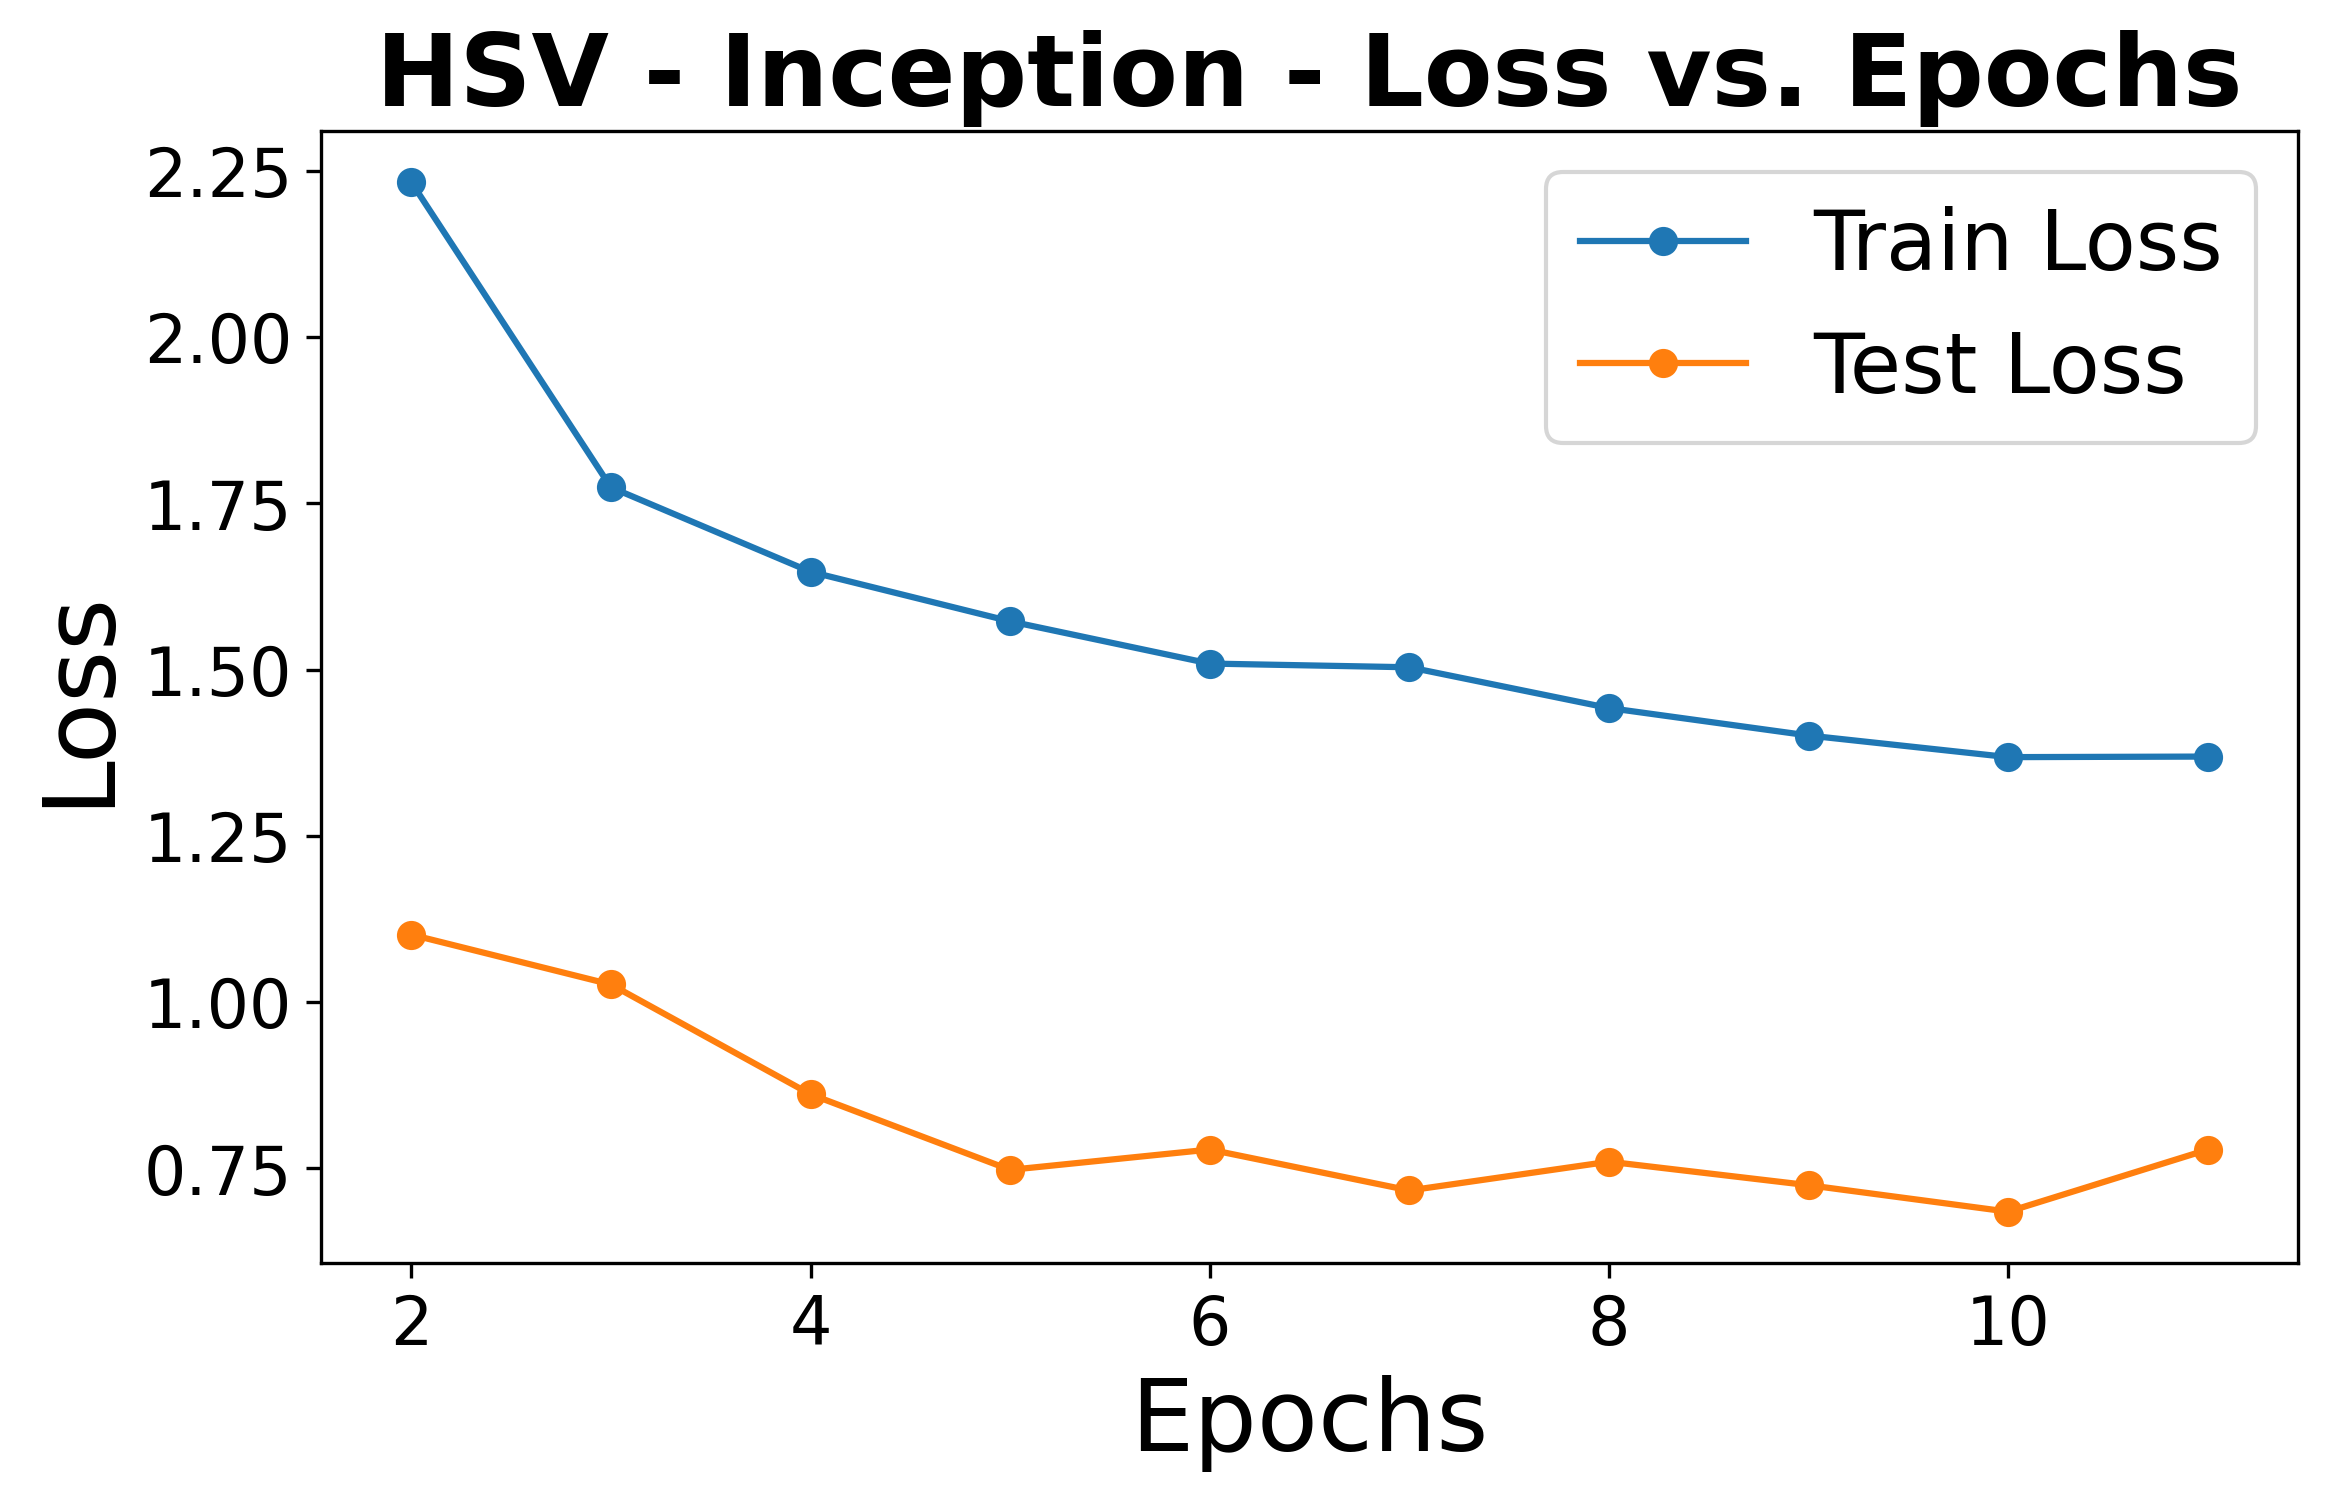

In [ ]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("HSV - Inception - Loss vs. Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("HSV_Inception_Loss_vs_Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("HSV_Inception_Loss_vs_Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

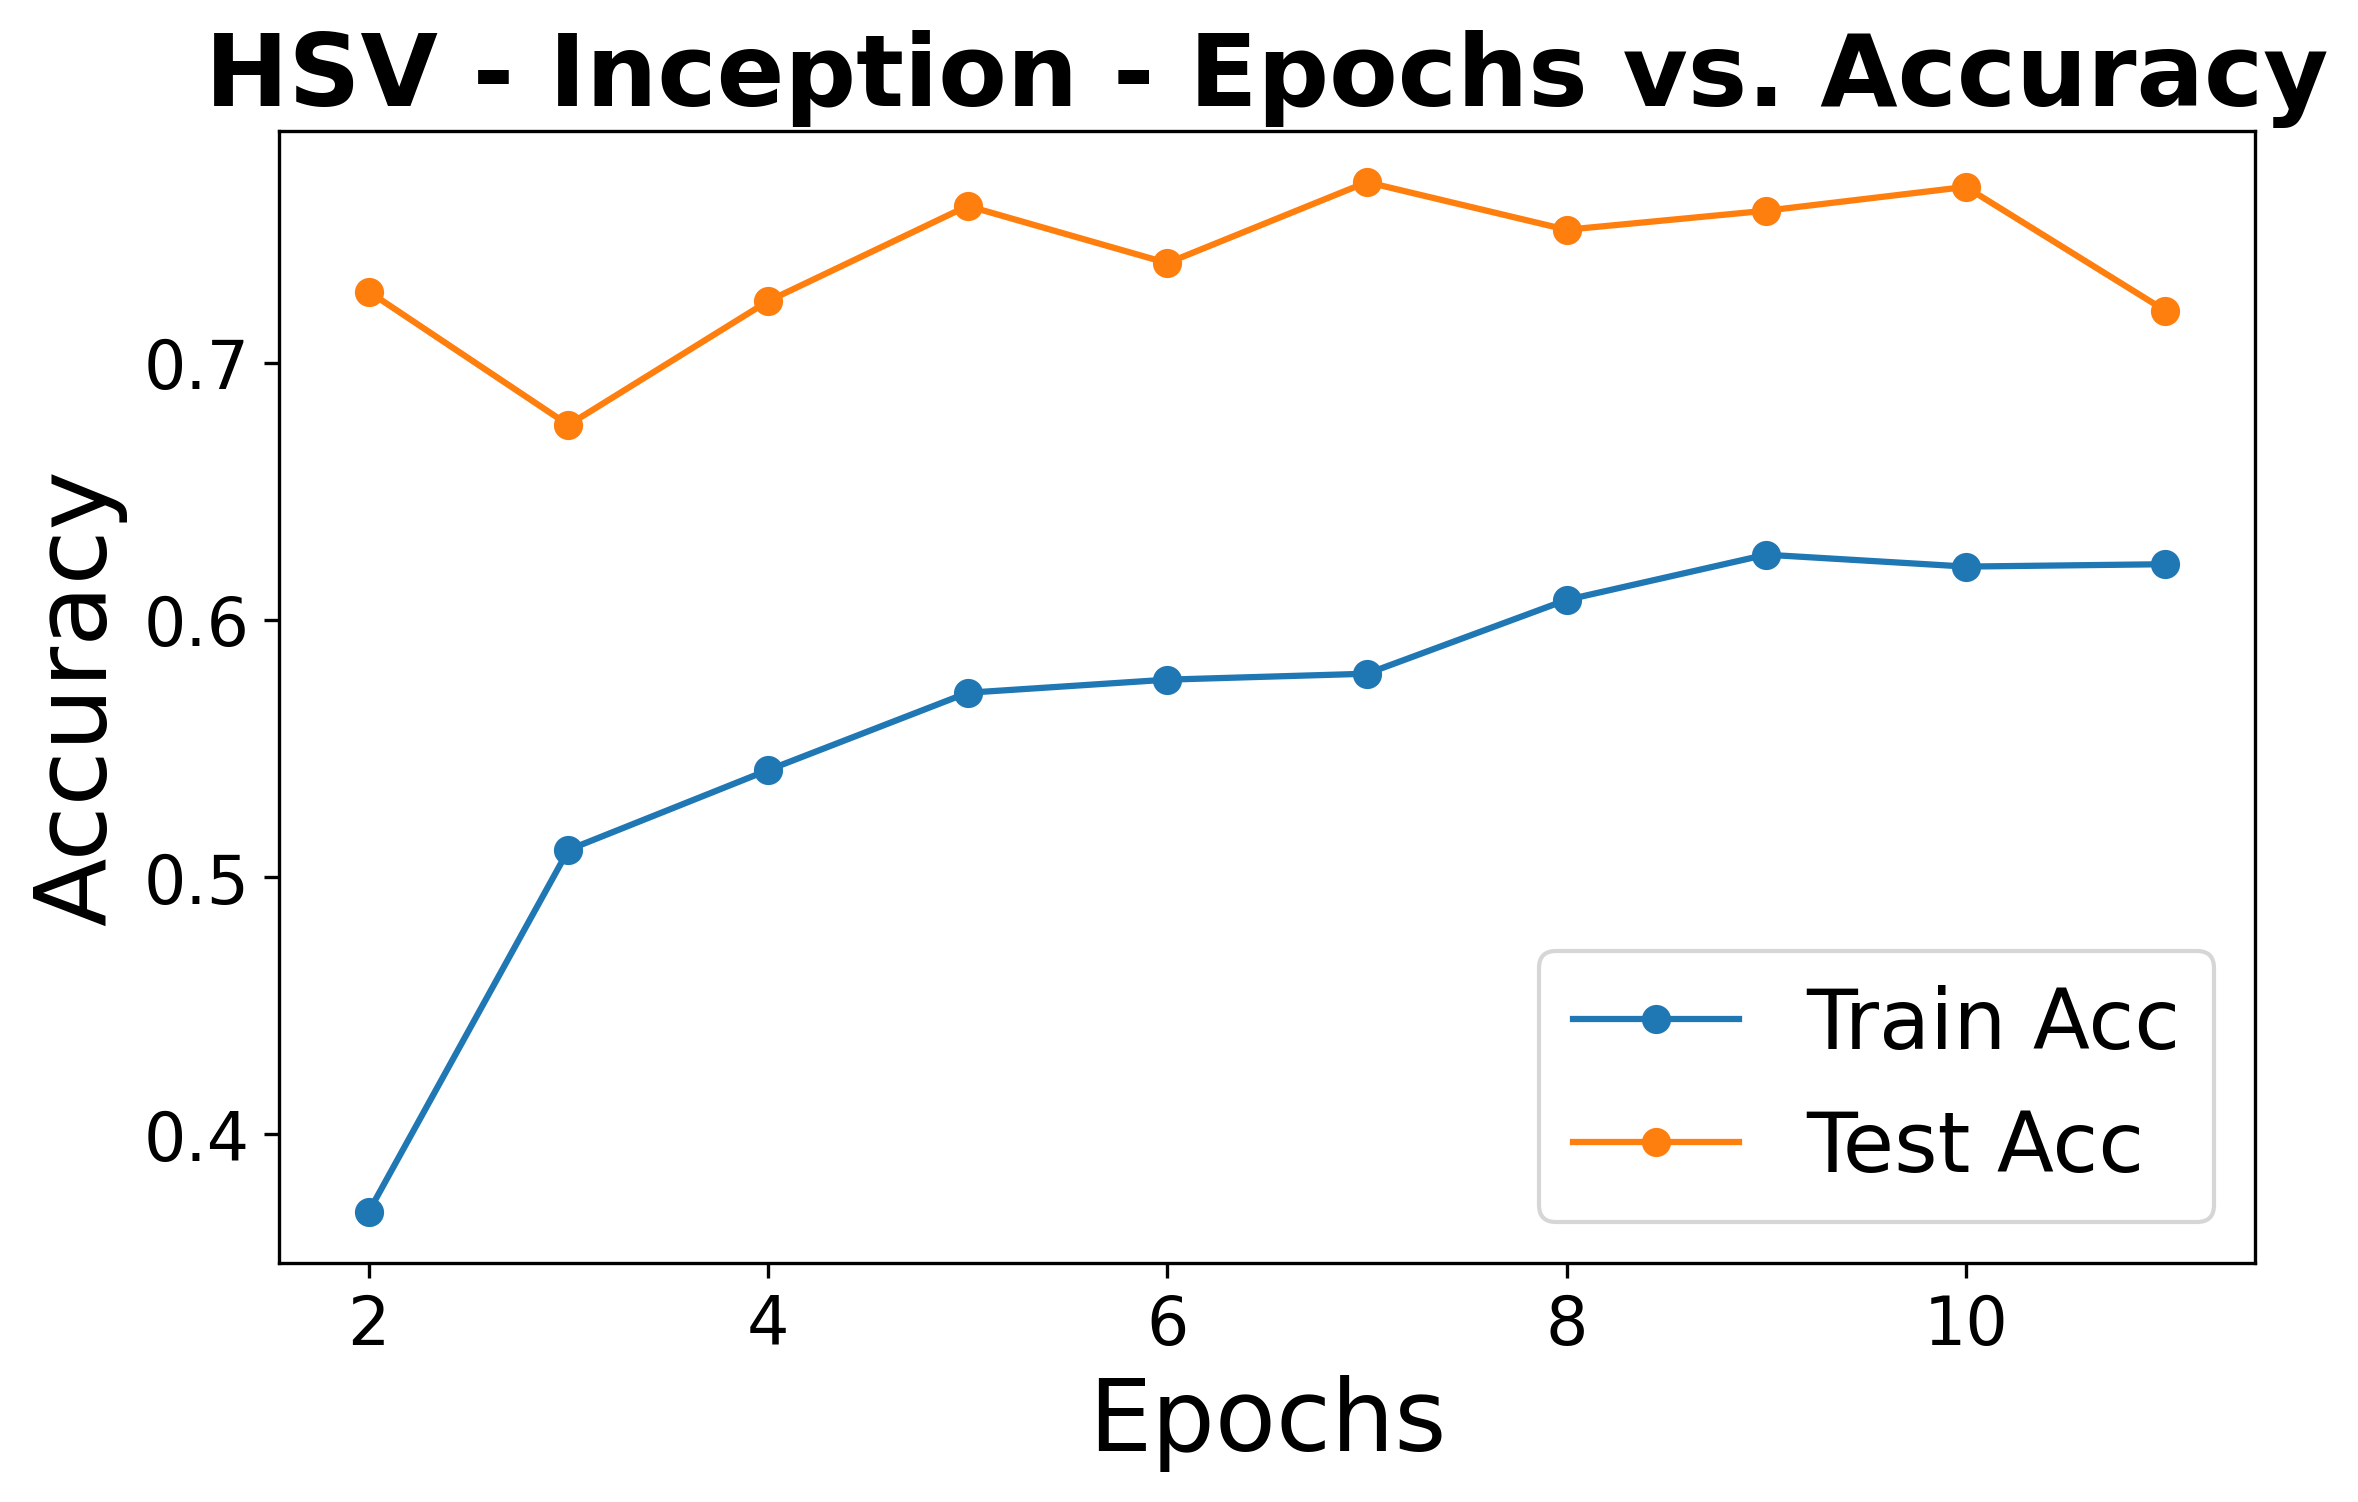

In [ ]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)


ax.plot(x, train_accuracy, '-o', label = "Train Acc", linewidth = 1.5)
ax.plot(x, test_accuracy, '-o', label = "Test Acc", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Accuracy", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("HSV - Inception - Epochs vs. Accuracy", fontsize = 24, fontweight = 'bold')

plt.savefig("HSV_Inception_Epochs_vs_Accuracy.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("HSV_Inception_Epochs_vs_Accuracy.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, top=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(top)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in top:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        outputs = torch.stack(list(outputs), dim = 0)
        prec1, prec5 = accuracy(outputs, labels, top=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [ ]:
top1,top5=calc_accuracy(model_conv, test_loader)

In [ ]:
top1.avg

tensor(75.5556, device='cuda:0')

In [ ]:
top5.avg

tensor(98.8889, device='cuda:0')

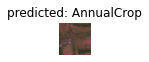

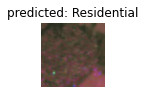

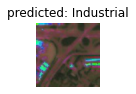

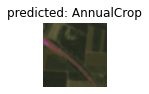

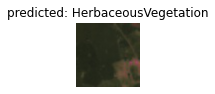

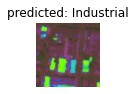

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

model_conv.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
      
        data, target = data.cuda(), target.cuda()
        
        out = model_conv(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

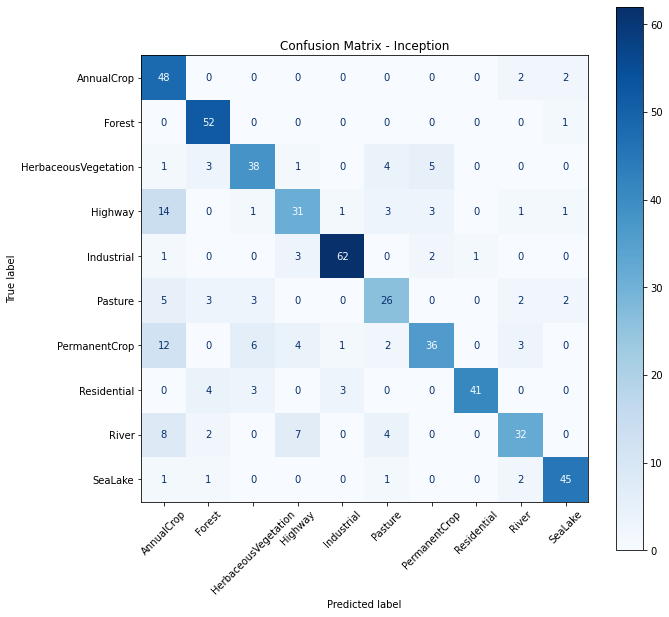

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

labels = np.arange(0,10)
label_dict = dict(zip(labels,classes))
conf = confusion_matrix(y_pred= pred, y_true = correct)
p = ConfusionMatrixDisplay(conf,display_labels = classes)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix - Inception')

p.plot(ax=ax,xticks_rotation=45, cmap = "Blues")
plt.savefig('HSV_Inception_Confusion_Matrix.jpg',dpi = 300, bbox_inches = 'tight')
plt.savefig('HSV_Inception_Confusion_Matrix.pdf',dpi = 300, bbox_inches = 'tight')

x = {'HSV_Inception_Train_Acc':train_accuracy,'HSV_Inception_Test_Acc':test_accuracy, 'HSV_Inception_Train_Loss':train_loss,'HSV_Inception_Test_Loss':test_loss,'HSV_Inception_Top_1':85.556,'HSV_Inception_Top_5':99.26}
import pandas as pd
DF = pd.DataFrame.from_dict(x)
DF.to_csv('HSV_Accuracy_Inception.csv')

download_files = ['HSV_Inception_Confusion_Matrix.jpg','HSV_Inception_Confusion_Matrix.pdf',"HSV_Inception_Loss_vs_Epochs.jpg","HSV_Inception_Loss_vs_Epochs.pdf","HSV_Inception_Epochs_vs_Accuracy.jpg","HSV_Inception_Epochs_vs_Accuracy.pdf",'HSV_Accuracy_Inception.csv']
from google.colab import files
for i in download_files:
  files.download(i)